In [1]:
# parameters
CATEGORIES = 10
TEST_SIZE = 10000


In [2]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Assigning the features to the 'data' variable and labels to the 'labels' variable.
data, labels = mnist['data'], mnist['target']


/home/adi/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
### preprocessing 

def preprocess(X, y):
    # normalize values to be between 0 and 1
    X_normalized = X / 255
    # insert column of ones as the first column of the data for bias calc down the line 
    size = X_normalized.shape[0]
    X_tilda = np.insert(X_normalized, 0, np.ones(size), axis=1)
    # convert labels to integers 
    y = y.astype(int).values

    # split the dataset to a test set and a training set 
    return train_test_split(X_tilda, y, test_size=TEST_SIZE, random_state=42)

# preprocess the data using the preprocess function
data_train, data_test, labels_train, labels_test = preprocess(data, labels)

# printing "done" to indicate the completion of the preprocessing.
print("done")


done


In [4]:
# create a binary classifier class
class BinaryClassifier:
    
    def __init__(self, features, class_label):
        self.max_iterations = 1000
        self.max_patience = 100 
        self.weights = np.random.randn(1, features)
        self.pocket_weights = self.weights
        # the evaluation is done using in sample error whos values are between 0 and 1 
        # so an inital pocket_weights_evaluation > 1 garuntees the first evaluatoin 
        # will be better then the current evaluation
        self.pocket_weights_evaluation = 1.01
        self.label = class_label
        # variales to track loss throughout time 
        self.loss_history= []
        self.pocket_loss_history = []
        
        
    def train(self, X_train, y_train):
        y_train = self.preprocess(y_train) 
        current_patience = 0 
        for i in range(self.max_iterations):
            
            if (current_patience == self.max_patience):
                # if there wasnt an update to the pocket_weights in the last max_patience 
                # training rounds then we end the training 
                return  
            
            self.train_single_round(X_train, y_train)
            curr_eval = self.evaluate(X_train,y_train)
            self.loss_history.append(curr_eval)
            self.pocket_loss_history.append(self.pocket_weights_evaluation)
            if curr_eval < self.pocket_weights_evaluation:
                
                current_patience = 0
                self.pocket_weights = self.weights
                self.pocket_weights_evaluation = curr_eval
                
                if self.pocket_weights_evaluation == 0:
                    # if we linearly seprated the data then there is no better clasifier 
                    # so we do not need to keep training to find one 
                    # so we exit the function 
                    return 
            else :
                current_patience +=1

    def train_single_round(self, X_train, y_train):
        
        #loop over training data
        for Xt, yt in zip(X_train, y_train):
            
            prediction = np.sign(np.dot(self.weights, Xt))
            # run prediction until we get to a missclsified exapmle
            if yt * prediction  < 0:
                # update the wweights and exit the function 
                self.weights = self.weights + (yt * Xt)
                return 
    
    def evaluate(self, X_train, y_train) :
        # calculate all predictions for the training data with the current weights 
        predictions = np.sign(np.dot(self.weights, X_train.T)) 
        # count wroung predictions
        wroung_predictions_count = np.count_nonzero(predictions != y_train)
        # get the number of training examples 
        size = X_train.shape[0]
        return wroung_predictions_count / size
        
    def preprocess(self, labels):
        return np.where(labels == self.label, 1, -1)
                
    def predict(self, datom):
        return np.sign(np.dot(self.pocket_weights, datom)).astype(int)
    
    
    print("done")

done


In [5]:
# create and train all binariy classifires 0 to 9 and store them in a list 

binary_classifires = []
for i in range(CATEGORIES):#CATEGORIES
    binary_classifier = BinaryClassifier(data_train.shape[1], i)
    binary_classifier.train(data_train, labels_train)
    binary_classifires.append(binary_classifier)
print("done ")


done 


In [6]:
# create a multy class clssiffer based on the binary classifires we trained 

class MultyClassClassifier:
    
    def __init__(self,binary_classifires):
        # get the pocket weights from all the binary classifires and put them all into one matrix  
        pocket_weights_list = [binary_classifire.pocket_weights for binary_classifire in  binary_classifires ]
        self.weights  = np.concatenate(pocket_weights_list)

    def predict(self, datom):
        return np.argmax(np.dot(self.weights,datom))
    
    def batch_predict(self, data):
        return np.argmax(np.dot(self.weights,data.T), axis = 0)

multy_class_classifier = MultyClassClassifier(binary_classifires)
print("done ")


done 


In [7]:
# create a confusion_matrix 
def create_confusion_matrix(true_labels, pred_labels, num_classes):
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(true_labels, pred_labels):
        confusion_matrix[true_label, pred_label] += 1
    return confusion_matrix

test_pred = multy_class_classifier.batch_predict(data_test)
multy_class_confusion_matrix = create_confusion_matrix(labels_test, test_pred, CATEGORIES)

confusion_matrices = []

for i in range(CATEGORIES):
    
    binary_classifier = binary_classifires[i]
    test_pred = binary_classifier.predict(data_test.T)
    binary_labels_test = binary_classifier.preprocess(labels_test)
    #  change predictions to be 0 and 1 for confusion matrix insertion
    test_pred = np.where(test_pred == 1, 0, 1) 
    binary_labels_test = np.where(binary_labels_test == 1, 0, 1)
    
    confusion_matrix =  create_confusion_matrix(binary_labels_test, test_pred[0], 2)
    confusion_matrices.append(confusion_matrix)

print("done")

done


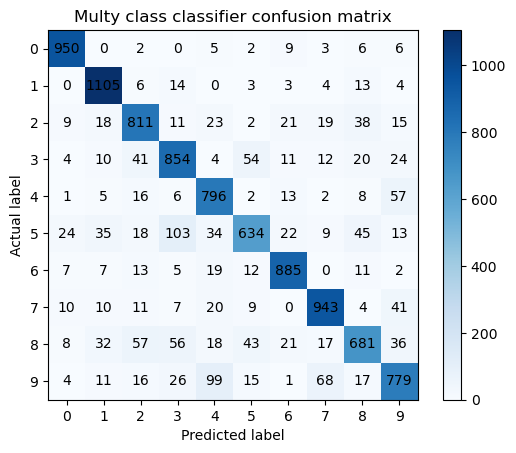

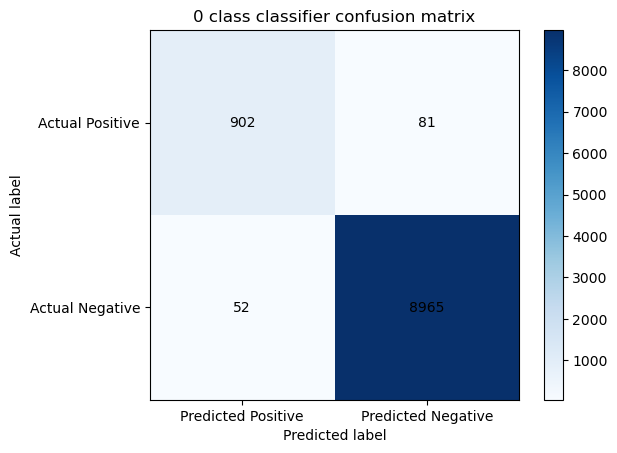

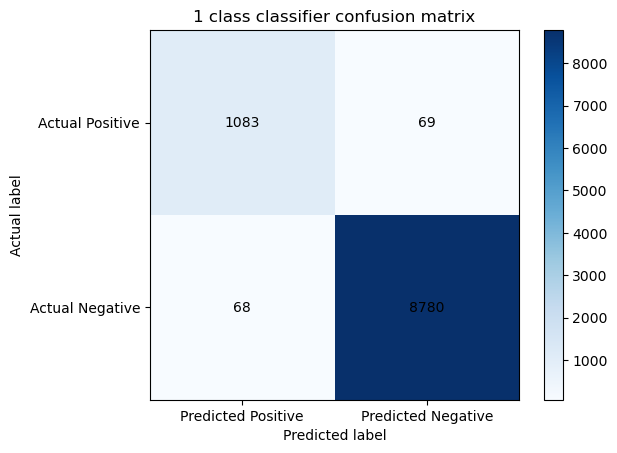

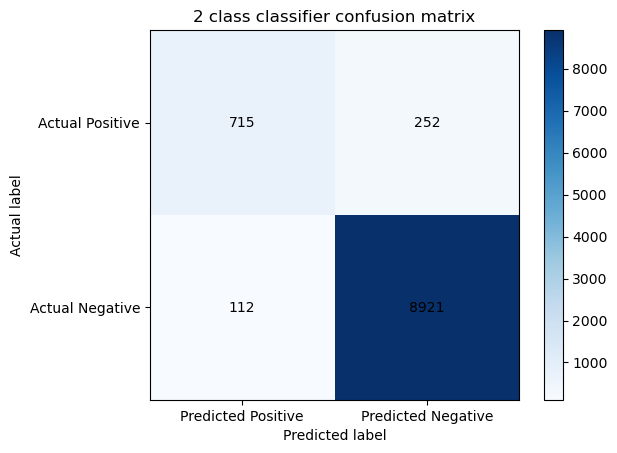

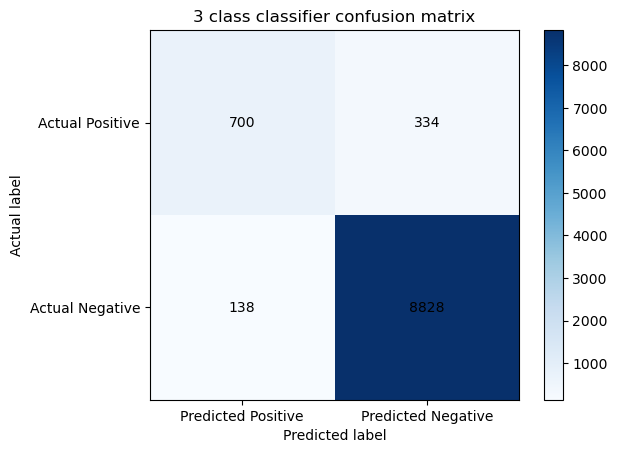

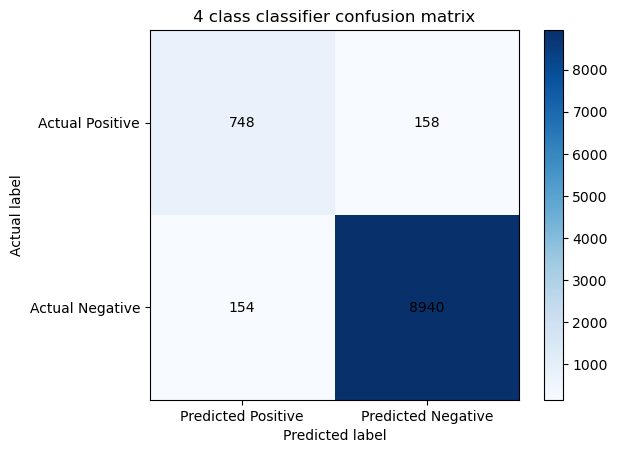

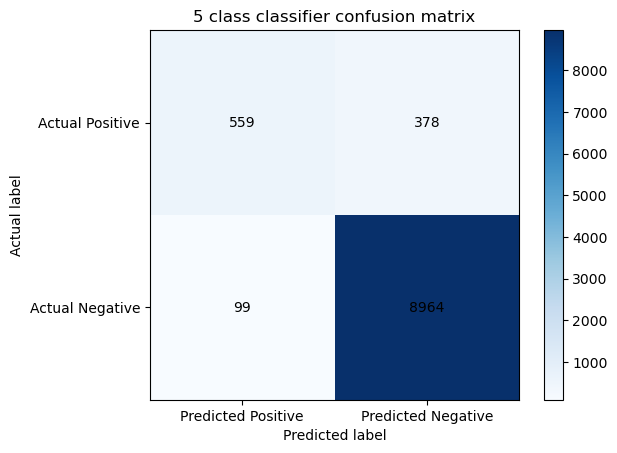

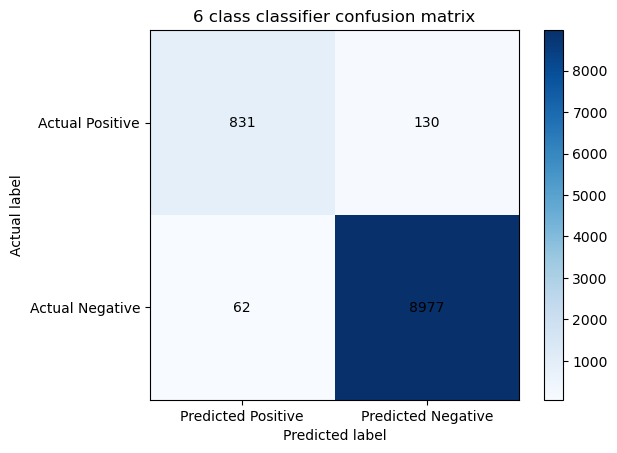

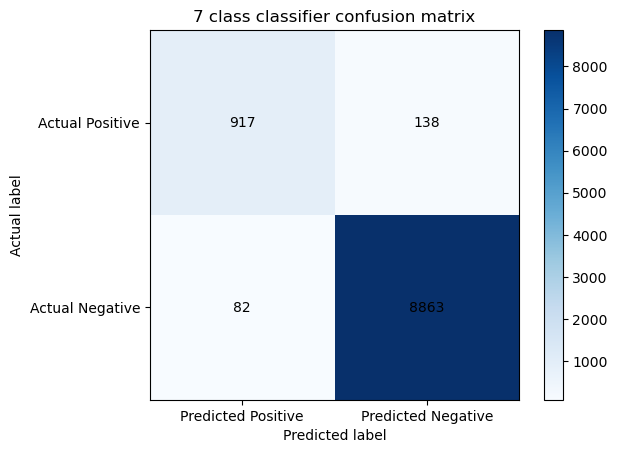

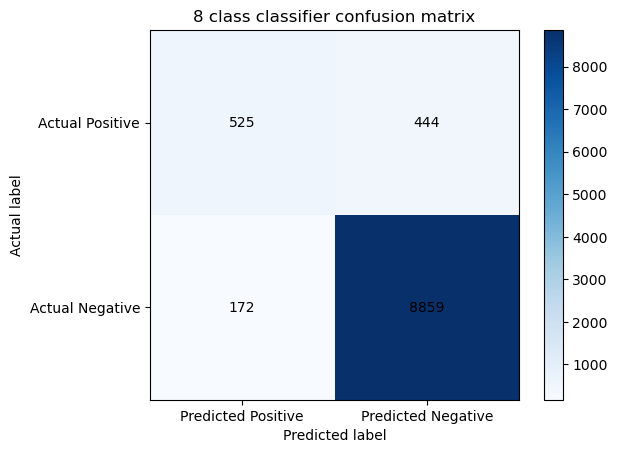

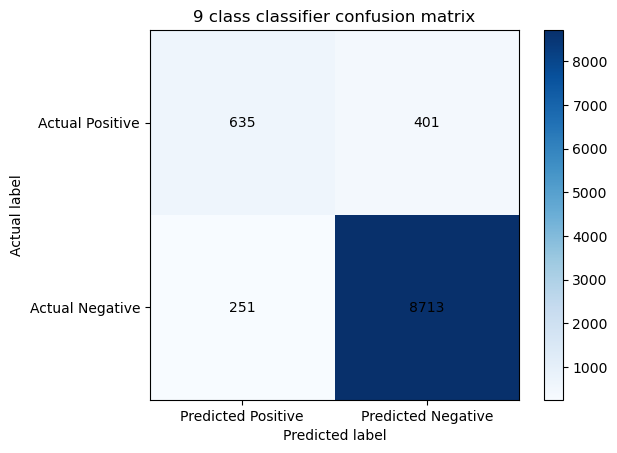

In [9]:
# plot confusion matricies
from matplotlib import pyplot as plt

def plot_confusion_matrix(matrix, x_class_names, y_class_names, title):
    _ , axis = plt.subplots()
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]): # a confusion matrix is a square matrxi
            axis.text(j, i, format(matrix[i, j], 'd'), ha="center", va="center", color="black")
    
    plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(x_class_names))
    plt.xticks(tick_marks, x_class_names)
    plt.yticks(tick_marks, y_class_names)

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

category_names =  [i for i in range(10)]
plot_confusion_matrix(multy_class_confusion_matrix, category_names,
                      category_names,"Multy class classifier confusion matrix")

x_category_names = [ "Predicted Positive", "Predicted Negative"]
y_category_names = [ "Actual Positive", "Actual Negative"]

for i in range(len(confusion_matrices)):
    plot_confusion_matrix(confusion_matrices[i],
                          x_category_names, y_category_names,
                         f"{i} class classifier confusion matrix")




In [10]:
# determine the accuracy of the multy class classifier
correcetly_classified = 0 
for i in range(10):
    correcetly_classified += multy_class_confusion_matrix[i][i]

multy_class_accuracy = correcetly_classified / data_test.shape[0]
print(f"multy class classifier Accuracy =  {multy_class_accuracy}")

for i in range(CATEGORIES):
    curr_confusion_matrix = confusion_matrices[i] 
    true_positive = curr_confusion_matrix[0,0]
    false_positive = curr_confusion_matrix[1,0]
    true_negative = curr_confusion_matrix[1,1]
    false_negative = curr_confusion_matrix[0,1]
    sensitivity = true_positive / (true_positive + false_negative)
    selectivity = true_negative / (true_negative + false_positive)
    print(f"{i} classifier Sensitivity = {sensitivity} | Selectivity = {selectivity}")

multy class classifier Accuracy =  0.8438
0 classifier Sensitivity = 0.9175991861648016 | Selectivity = 0.9942331152267938
1 classifier Sensitivity = 0.9401041666666666 | Selectivity = 0.9923146473779385
2 classifier Sensitivity = 0.7394002068252327 | Selectivity = 0.987601018487767
3 classifier Sensitivity = 0.6769825918762089 | Selectivity = 0.9846085210796341
4 classifier Sensitivity = 0.82560706401766 | Selectivity = 0.9830657576424016
5 classifier Sensitivity = 0.5965848452508005 | Selectivity = 0.9890764647467726
6 classifier Sensitivity = 0.8647242455775234 | Selectivity = 0.9931408341630711
7 classifier Sensitivity = 0.8691943127962085 | Selectivity = 0.9908328675237563
8 classifier Sensitivity = 0.541795665634675 | Selectivity = 0.980954490089691
9 classifier Sensitivity = 0.612934362934363 | Selectivity = 0.9719991075412762


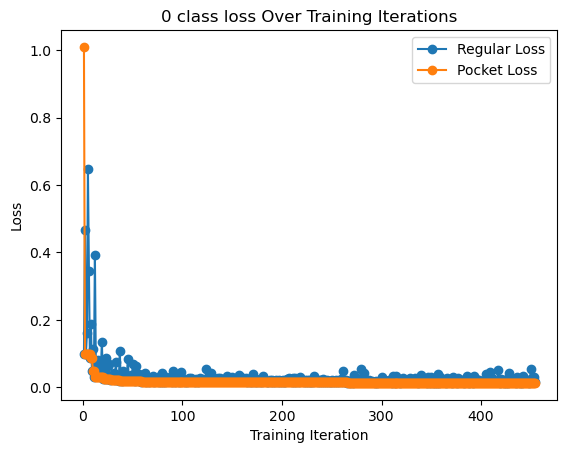

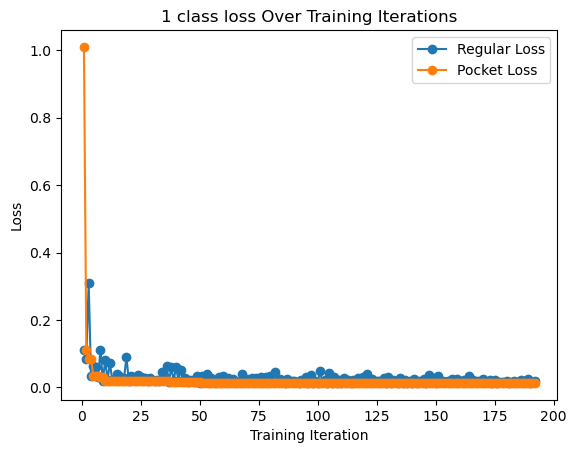

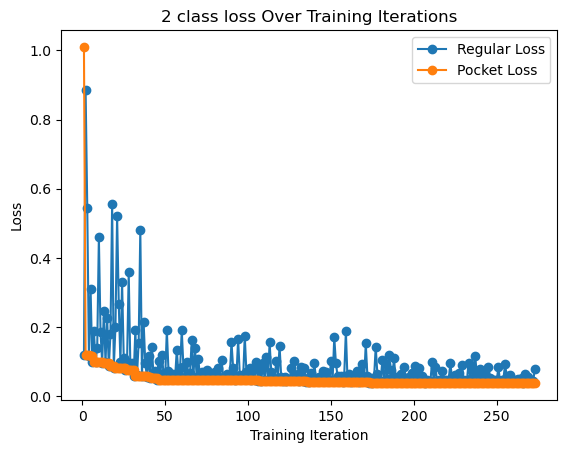

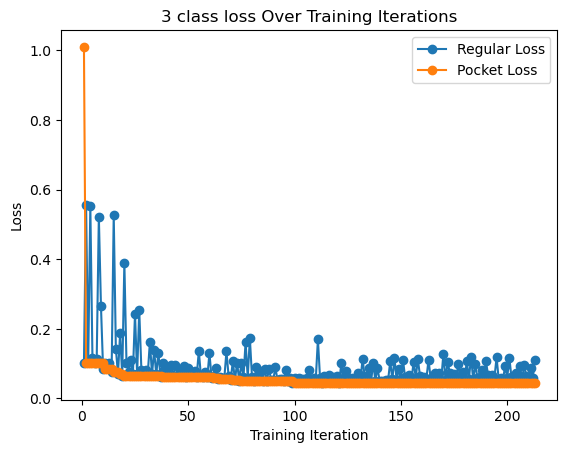

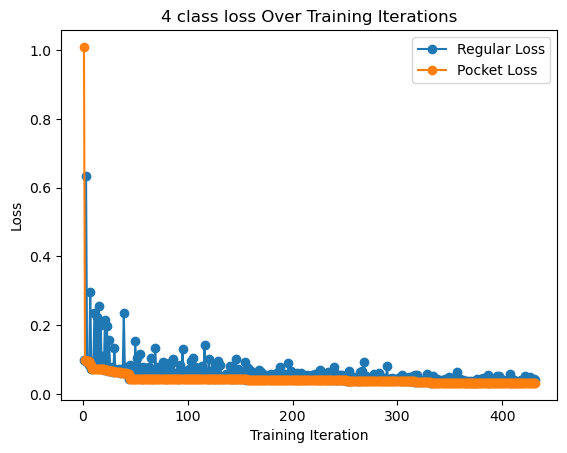

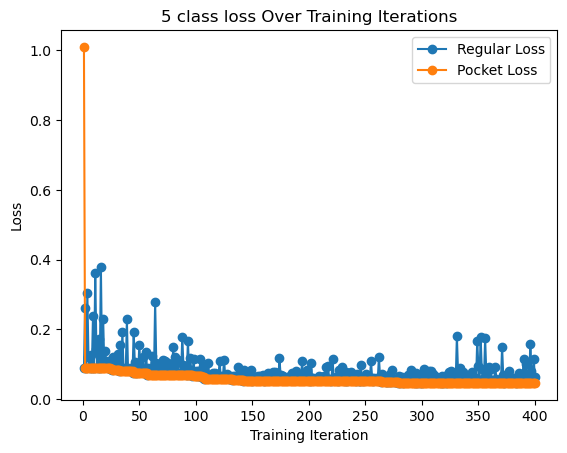

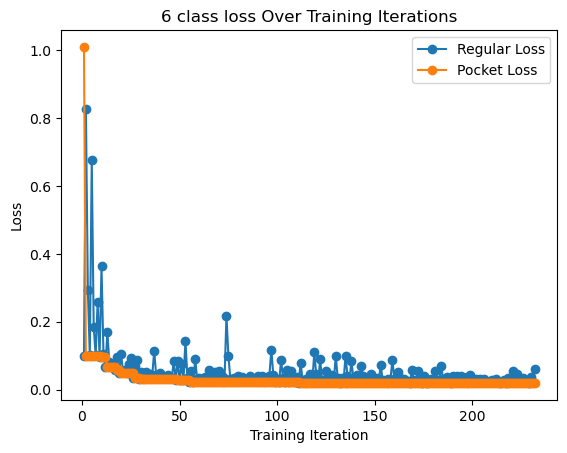

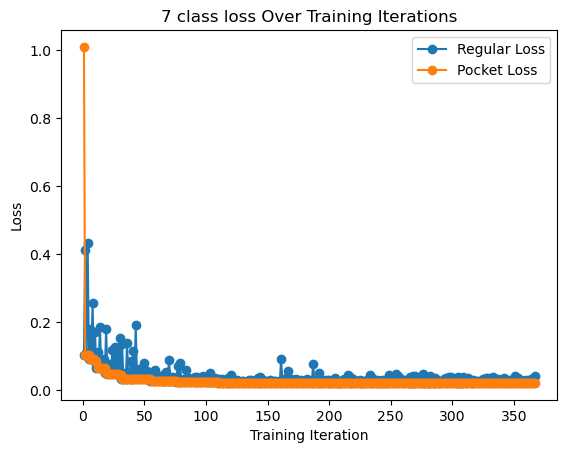

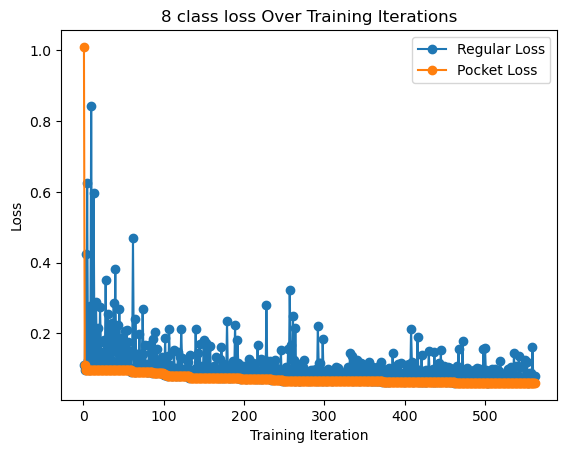

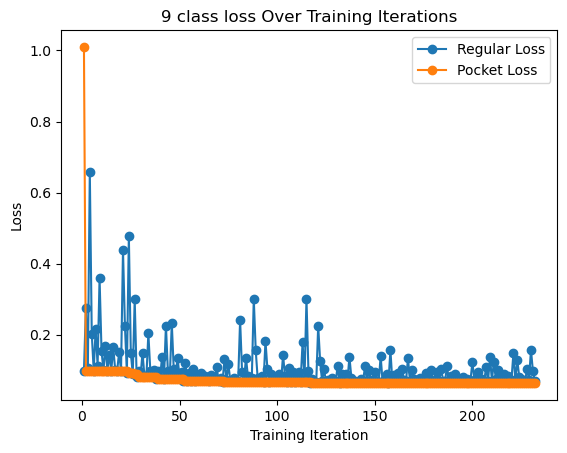

In [11]:
# plot loss throughout time 
def plot_loss_history(loss_history, pocket_loss_history, title):
    
    plt.plot(range(1, len(loss_history) +1), loss_history, label="Regular Loss", marker='o')
    plt.plot(range(1, len(pocket_loss_history) +1), pocket_loss_history,
             label="Pocket Loss", marker='o')
    
    plt.title(title)
    plt.xlabel("Training Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    
for i in range(CATEGORIES):
    plot_loss_history(binary_classifires[i].loss_history,
                      binary_classifires[i].pocket_loss_history,
                      f"{i} class loss Over Training Iterations" )